In [11]:
# Import necessary libraries
import sys
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Add source directory to path
sys.path.append('src/')

# Import custom modules
from SPM import SPM
from EDR import EDR
import gis_utils
import fanTopo
import plt_utils

In [ ]:
# Set DEM resolution
dem_interval = 20 # Two resolutions of DEM file were provided: 10 m and 20 m

# Define file paths
topo_pre_event = r"datasets\raw\tif\topo_PuTunPuNas_min_before2014_riverbed2014_" + str(dem_interval) + r"m.tif"
topo_post_event = r"datasets\raw\tif\topo_PuTunPuNas_2014_" + str(dem_interval) + r"m.tif"
shape_fan_boundary = r"datasets\raw\shape\PT2014.shp"

In [3]:
# Create shortest path distance object
shortest_path_distance = SPM(topo_post_event, shape_fan_boundary)

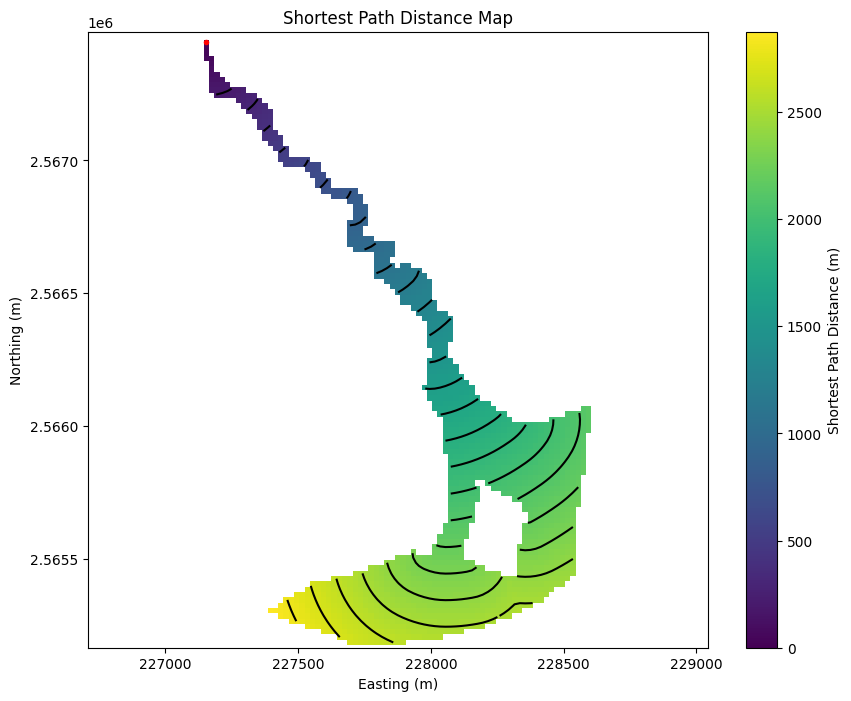

In [4]:
# Get coordinates within boundary
xMesh_crop, yMesh_crop, zMesh_crop, sMesh_crop = shortest_path_distance.within_boundary(pltFlag=True)

Processing shortest paths: 100%|██████████| 433/433 [00:18<00:00, 23.47it/s]


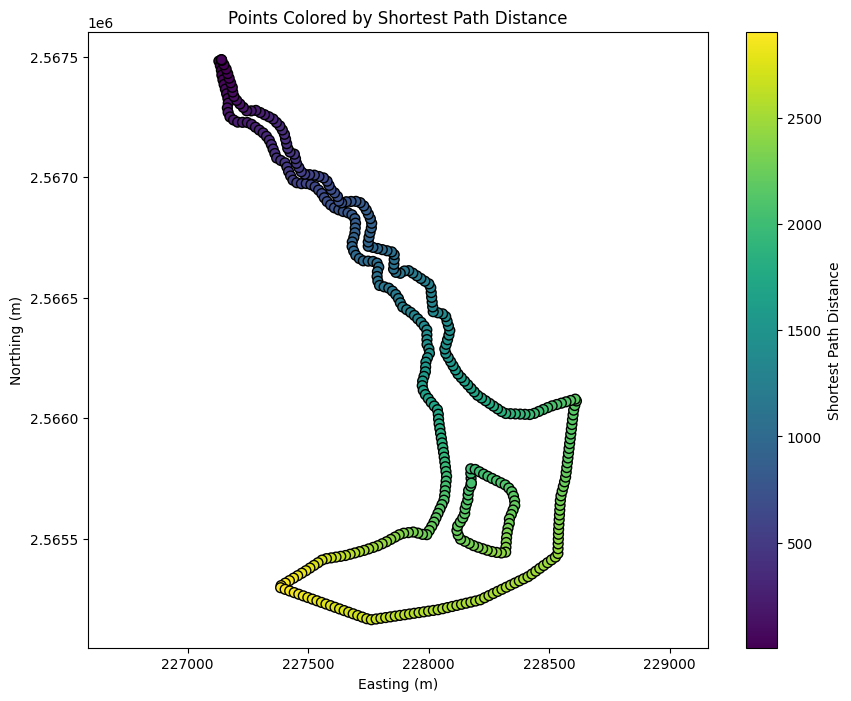

In [5]:
# Get coordinates along boundary
boundary_x, boundary_y, boundary_z, boundary_s = shortest_path_distance.along_boundary(pltFlag=True)

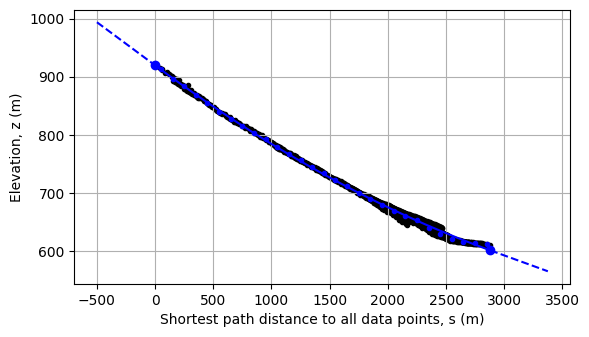

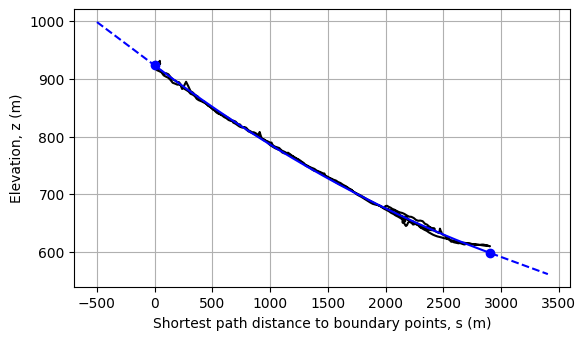

In [6]:
# Fit quadratic elevation-distance relationship
bin_size = 100
ds = 5
outlength = 500

# Apply filters to the data
fitting_s_z_within_boundary = EDR(sMesh_crop, zMesh_crop).medianFilter_on(bin_size, ds, outlength, pltFlag=True)
fitting_s_z_along_boundary = EDR(boundary_s, boundary_z).medianFilter_off(ds, outlength, pltFlag=True)

In [8]:
# Read the pre-event DEM
xMesh, yMesh, zMesh = gis_utils.read_geotiff(topo_pre_event)

# Get apex coordinates
xApex, yApex = shortest_path_distance.xyApex()

# Get the elevation of the apex
interp1d_func = interp1d(fitting_s_z_within_boundary[:, 0], fitting_s_z_within_boundary[:, 1], fill_value="extrapolate")
zApex = interp1d_func(0)

zTopo= fanTopo.fan_topo(xMesh, yMesh, zMesh, [xApex], [yApex], [zApex], {
            'caseName': 'myProfile',
            'sz_interpM': [fitting_s_z_within_boundary],
            })

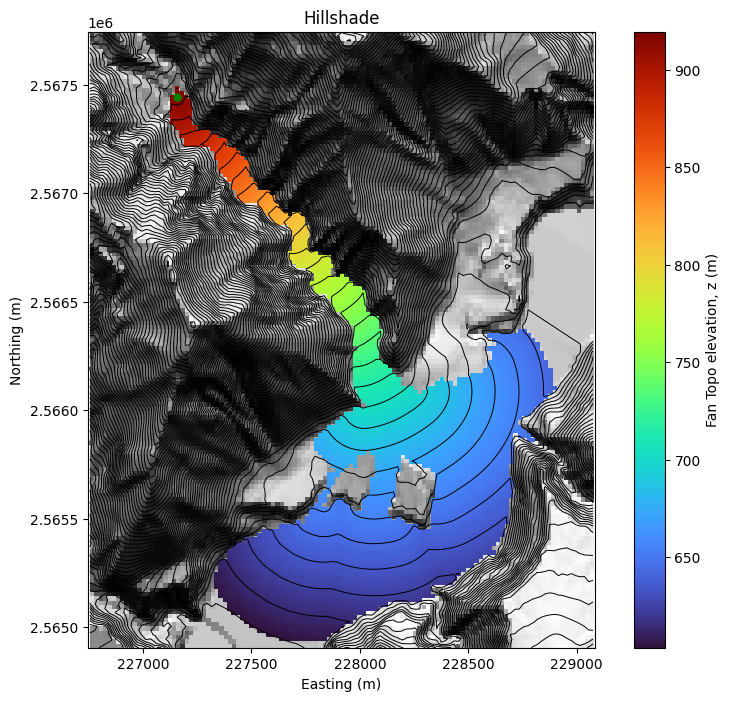

In [16]:
zTopoMesh = zTopo[0]
nanIndexMesh = np.isnan(zTopo[0])
zMapMesh = zTopoMesh.copy()
zMapMesh[nanIndexMesh] = zMesh[nanIndexMesh]
plt_utils.plot_hillshade(xMesh, yMesh, zMapMesh, azdeg=180, altdeg=45, vert_exag=5)
dxMesh = xMesh[0,1] - xMesh[0,0]
dyMesh = yMesh[0,0] - yMesh[1,0]
plt.imshow(zTopoMesh, extent=(xMesh.min()-dxMesh/2, xMesh.max()+dxMesh/2, yMesh.min()-dyMesh/2, yMesh.max()+dyMesh/2), origin='upper', cmap='turbo')
plt.colorbar(label = 'Fan Topo elevation, z (m)')
interval = 10
levels = np.arange(zMapMesh.min(), zMapMesh.max(), interval)
plt.contour(xMesh, yMesh, zMapMesh, levels=levels, colors='k', linewidths=0.7)
plt.plot(xApex, yApex, 'go', markersize=5)

In [10]:
# Get EPSG code and write results to GeoTIFF
epgs_code = gis_utils.get_epsg_code(topo_pre_event)
gis_utils.write_geotiff('results/zTopo_2014.tif', xMesh, yMesh, zTopo[0], epgs_code)
